In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr, pearsonr
import itertools


In [2]:
# Read feature importance data

dfs = []
scale_d = {'votespos': 0.1, 'votesneg': 0.5, 'pinned': 10}
for outcome in ['votespos', 'votesneg', 'pinned']:
    df = pd.read_csv(f'data/feature importance/feat_imp_{outcome}_v1.csv')
    df['Outcome'] = outcome
    df = df.melt(id_vars=['Feature', 'Outcome'], var_name='Measure',
                 value_name='Importance')
    df['Measure'] += ' (RF)'
    dfs.append(df)

regcoef = pd.read_csv('data/feature importance/feat_imp_reg_v1.csv', sep='\t',
                      names=['Feature', 'votespos', 'votesneg', 'pinned'],
                      header=0)

regcoef = regcoef.melt(id_vars=['Feature'], var_name='Outcome', value_name='Importance').dropna()
regcoef['Measure'] = 'St. Coef'
regcoef['s_Importance'] = regcoef['Importance'] < 0
regcoef['Importance'] = regcoef['Importance'].abs()
for outcome, scale in scale_d.items():
    regcoef.loc[regcoef['Outcome'] == outcome, 'Importance'] = regcoef.loc[regcoef['Outcome'] == outcome, 'Importance']/scale
dfs = pd.concat(dfs + [regcoef])
dfs.replace('Text uses second person pronouns', 'Uses 2nd person pronouns', inplace=True)
dfs.replace('Hours since publication of article', 'Hours from article publication', inplace=True)
dfs.replace('Comment author\'s followers (#)', 'Commenter\'s followers (#)', inplace=True)

/Users/Patrick/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Patrick/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_13122/2510653575.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(np.round(ax1.get_xticks()*scale_d[feat],6))
/Users/Patrick/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dty

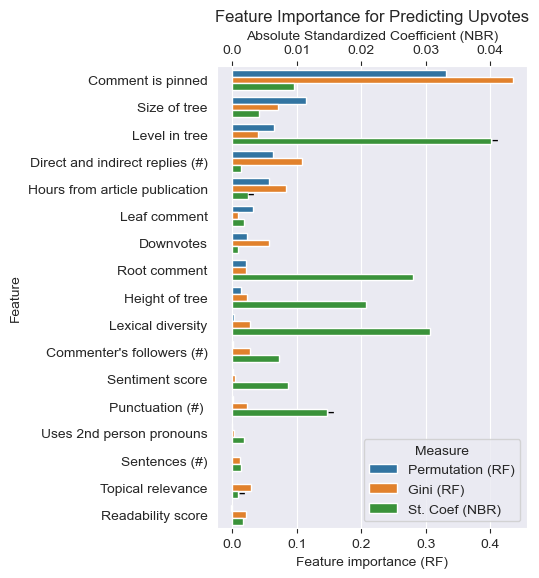

/Users/Patrick/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Patrick/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_13122/2510653575.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(np.round(ax1.get_xticks()*scale_d[feat],6))
/Users/Patrick/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dty

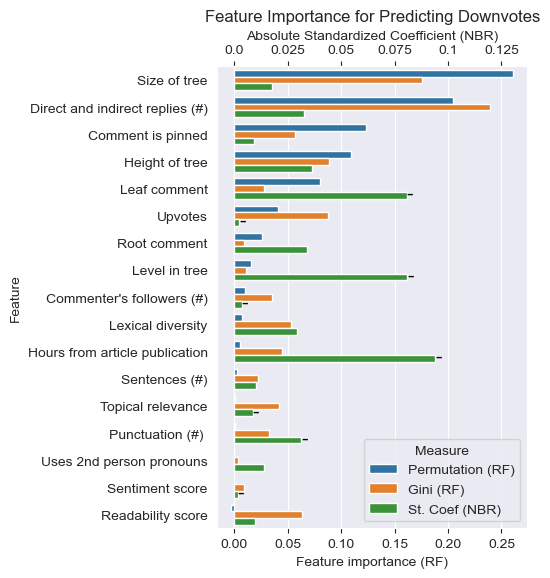

/Users/Patrick/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Patrick/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_13122/2510653575.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(np.round(ax1.get_xticks()*scale_d[feat],6))
/Users/Patrick/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dty

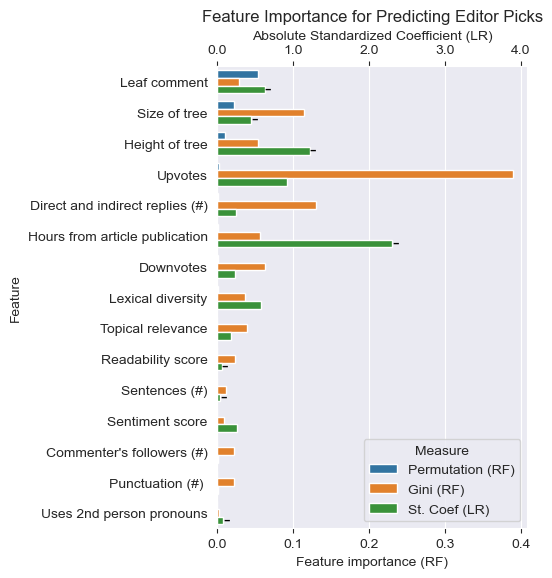

In [3]:
# Plot feature importance metrics

sns.set_style('darkgrid')

cname = {'votespos': 'Upvotes', 'votesneg': 'Downvotes', 'pinned': 'Editor Picks'}
for feat in ['votespos', 'votesneg', 'pinned']:
    if feat == 'pinned':
        suff = ' (LR)'
    else:
        suff = ' (NBR)'

    dat = dfs[dfs['Outcome']==feat].sort_values(['Measure', 'Importance'],
                                                           ascending=[True, False])
    # dat = dat.reset_index(drop=True).loc[list(range(15,30))+list(range(15))
    #                                      +list(range(30,45))].reset_index(drop=True)
    dat.replace('St. Coef', 'St. Coef' + suff, inplace=True)
    order = dat[dat['Measure'] == 'Permutation (RF)'].sort_values('Importance', ascending=False)['Feature']
    fig, ax1 = plt.subplots(figsize=(4, 6))
    g = sns.barplot(data=dat, y='Feature', x='Importance', hue='Measure',
                    width=0.75, hue_order=['Permutation (RF)','Gini (RF)', 'St. Coef' + suff],
                    order=order, orient='h')
    ax1.set_title(f'Feature Importance for Predicting {cname[feat]}')

    ax1.set_xlabel('Feature importance (RF)')
    ax2 = ax1.twiny()

    # Ensure ticks occur at the same positions, then modify labels
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticklabels(np.round(ax1.get_xticks()*scale_d[feat],6))
    g = sns.barplot(data=dat, y='Feature', x='Importance', hue='Measure',
                    width=0.75, hue_order=['Permutation (RF)','Gini (RF)', 'St. Coef' + suff], 
                    order = order, orient='h')
    ax2.set_xlabel('Absolute Standardized Coefficient' + suff)
    ax2.legend().remove()

    negs = dat[dat['Measure']=='St. Coef'+ suff].set_index('Feature').loc[order].reset_index()
    for ix in negs[negs['s_Importance']]['Importance'].reset_index().values:
        ax1.text(ix[1], ix[0] + 0.35, '-', fontsize=14, color='black')
    ax2.set_zorder(-1)
    ax1.legend(loc='lower right', title='Measure')

    # plt.savefig(f'figs/feature_importance_{feat}.pdf', bbox_inches='tight')
    plt.show()

In [4]:
# calculate correlation between feat importance measures

for outcome in ['votespos', 'votesneg', 'pinned']:
    print(outcome)
    for c in itertools.combinations(['Gini (RF)', 'Permutation (RF)', 'St. Coef'], 2):
        importance1 = dfs[(dfs['Measure']==c[0])&(dfs['Outcome']==outcome)]['Importance']
        importance2 = dfs[(dfs['Measure']==c[1])&(dfs['Outcome']==outcome)]['Importance']
        
        correlation, p_value = spearmanr(importance1, importance2)
        correlation_pearson, p_value_pearson = pearsonr(importance1, importance2)
        print(*c)
        print(f"Rank correlation: {correlation}")
        print(f"P-value: {p_value}")
        # print(f"Pearson correlation: {correlation_pearson}")
        # print(f"P-value: {p_value_pearson}")
    print()

votespos
Gini (RF) Permutation (RF)
Rank correlation: 0.6813725490196079
P-value: 0.002596603135725265
Gini (RF) St. Coef
Rank correlation: -0.2785278170257984
P-value: 0.27901693031201474
Permutation (RF) St. Coef
Rank correlation: -0.06993870295361457
P-value: 0.7896800581976334

votesneg
Gini (RF) Permutation (RF)
Rank correlation: 0.5612745098039216
P-value: 0.019063465403200246
Gini (RF) St. Coef
Rank correlation: 0.05392156862745098
P-value: 0.8371514461082935
Permutation (RF) St. Coef
Rank correlation: -0.08578431372549021
P-value: 0.7433950261372769

pinned
Gini (RF) Permutation (RF)
Rank correlation: 0.7721182707808439
P-value: 0.0007434940632609764
Gini (RF) St. Coef
Rank correlation: 0.28928571428571426
P-value: 0.29566536100437785
Permutation (RF) St. Coef
Rank correlation: 0.22877578393506487
P-value: 0.4121369651674516

